<a href="https://colab.research.google.com/github/ryanraba/casa6/blob/master/CASA_image_anomaly_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install imgpy > /dev/null
import urllib.request

urllib.request.urlretrieve("https://www.cv.nrao.edu/~rraba/Examples.GOOD.gif", "Examples.GOOD.gif")
urllib.request.urlretrieve("https://www.cv.nrao.edu/~rraba/Examples.BOTH.gif", "Examples.BOTH.gif")
urllib.request.urlretrieve("https://www.cv.nrao.edu/~rraba/Examples.TYPE1.gif", "Examples.TYPE1.gif")
urllib.request.urlretrieve("https://www.cv.nrao.edu/~rraba/Examples.TYPE2.gif", "Examples.TYPE2.gif");

# Data Preparation
Reads in data and preps for training.  This will categorize our training data, but we will not actually use that knowledge for training.

Instead, we will train with only the good examples to produce an estimator of "goodness".  For testing, we will feed in some good examples and some bad/artifact examples and see if our estimator error changes accordingly.  Obviously the good examples used for testing must be held out of training.

We will also use a utility to randomly alter each sample image for each training epoch.  This will give the appearance of having more data than we really do and help the model to generalize better (avoid overfitting)

In [151]:
import PIL
import numpy as np
import imgpy
import matplotlib.pyplot as plt
from keras.utils import to_categorical
np.random.seed(17)

# because the axes are in the image
crop_box = (172, 61, 650, 539)

# convert from raw image format to a numpy data matrix
# downsample a bit for speed (we're in a free cloud environment here)
# build targets vector as we go (truth)
images = imgpy.Img(fp='Examples.BOTH.gif').frames
dm = np.array([np.array(dv.crop(crop_box).resize(size=(408,304), resample=PIL.Image.BILINEAR)) for dv in images])
targets = np.zeros((len(images)))  # both kinds of bad are a 0
print('BOTH count',len(images))

images = imgpy.Img(fp='Examples.TYPE1.gif').frames
dm = np.concatenate((dm, np.array([np.array(dv.crop(crop_box).resize(size=(408,304), resample=PIL.Image.BILINEAR)) for dv in images])), axis=0)
targets = np.concatenate((targets, np.zeros((len(images)))+1), axis=0)  # type1 bad is a 1
print('TYPE1 count',len(images))

images = imgpy.Img(fp='Examples.TYPE2.gif').frames
dm = np.concatenate((dm, np.array([np.array(dv.crop(crop_box).resize(size=(408,304), resample=PIL.Image.BILINEAR)) for dv in images])), axis=0)
targets = np.concatenate((targets, np.zeros((len(images)))+2), axis=0)  # type2 bad is a 2
print('TYPE2 count',len(images))

images = imgpy.Img(fp='Examples.GOOD.gif').frames
dm = np.concatenate((dm, np.array([np.array(dv.crop(crop_box).resize(size=(408,304), resample=PIL.Image.BILINEAR)) for dv in images])), axis=0)
targets = np.concatenate((targets, np.zeros((len(images)))+3), axis=0)  # lets say GOOD images are a 3
print('GOOD count', len(images))

# normalize to 0, 1
dm = dm.astype(np.float32)
for ii in range(len(dm)):
  dm[ii] = (dm[ii] - np.min(dm[ii])) / np.ptp(dm[ii])
dm = dm[..., np.newaxis]

BOTH count 168
TYPE1 count 153
TYPE2 count 157
GOOD count 803


In [115]:
# randomly divide good data in to training and validation
# model is trained with train and validated with val
np.random.seed(42)

good = np.where(targets == 3)[0]
train = np.random.choice(good, int(0.8*len(good)), replace=False)
val = np.random.choice(np.setdiff1d(good, train), int(0.2*len(good)), replace=False)
print(len(good), len(train), len(val))

803 642 160


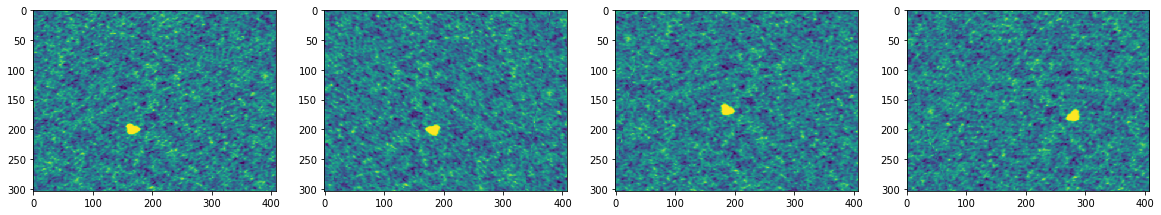

In [153]:
# because there are only ~1k samples, models are going to overfit and be super sensitive to val splits
# heres a neat trick where we can augment our training data by randomly moving it around
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='wrap')

datagen.fit(dm)

# observe, same training image four different ways
ff, aa = plt.subplots(1,4, figsize=(20,20))
aa[0].imshow(dm[train[0]][:,:,0])
aa[1].imshow(datagen.random_transform(dm[train[0]], seed=17)[:,:,0])
aa[2].imshow(datagen.random_transform(dm[train[0]], seed=138)[:,:,0])
aa[3].imshow(datagen.random_transform(dm[train[0]], seed=1989)[:,:,0]);

# Anomaly Detection
Train an autoencoder on only the good samples. An autoencoder is a model where the outputs match the inputs.  This will encode the images to an internal compressed representation (some form of PCA) and then decode back to a close approximation of the original image. 

The goal is to force some generalization of common characteristics in the internal latent space that produces low reconstruction error for good samples but larger reconstruction error for anomaly samples.  This tends to work best over just a few epochs, then the model gets too smart.

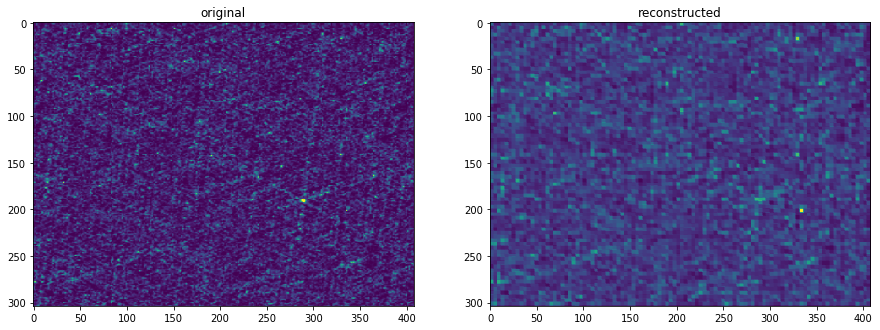

In [156]:
# here we build and train a CNN model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from IPython.display import clear_output
from matplotlib import colors

# nifty little thing to display progress as we train
class ModelCheck(Callback):
  def on_epoch_end(self, epoch, logs={}):
    sample = 22 # or whatever
    clear_output(wait=True)
    reconstructed = self.model.predict(dm[val[sample:sample+1]])[0,:,:,0]
    ff, aa = plt.subplots(1,2,figsize=(15,15))
    aa[0].imshow(dm[val[sample]][:,:,0], norm=colors.PowerNorm(3))
    aa[0].set_title('original')
    aa[1].imshow(reconstructed, norm=colors.PowerNorm(3))
    aa[1].set_title('reconstructed')
    plt.show()

ins = Input(shape=(dm.shape[1], dm.shape[2], 1))
hh = Conv2D(32, 2, activation='relu', padding='same')(ins)
hh = MaxPooling2D(pool_size=2, strides=2, padding='same')(hh)
hh = Conv2D(8, 1, activation='relu', padding='same')(hh)
hh = MaxPooling2D(pool_size=2, strides=2, padding='same')(hh)
hh = Conv2D(4, 1, activation='relu', padding='same')(hh)
hh = UpSampling2D((2, 2))(hh)
hh = Conv2D(8, 1, activation='relu', padding='same')(hh)
hh = UpSampling2D((2, 2))(hh)
hh = Conv2D(32, 2, activation='relu', padding='same')(hh)
outs = Conv2D(1, 1, activation='tanh', padding='same')(hh)

detector = Model(ins, outs)
detector.compile(optimizer='adam', loss='binary_crossentropy')

# we need the generator to yeild a tuple of the same image (so in=out)
def image_generator(idxs):
    for x_batch, y_batch in datagen.flow(dm[idxs], dm[idxs], batch_size=32): 
        yield (x_batch, x_batch)

# fit the model using augmented training data
detector.fit_generator(image_generator(train),
                       steps_per_epoch=len(train) / 32, epochs=1,
                       validation_data=image_generator(val), validation_steps=len(val)/32,
                       callbacks=[ModelCheck(),
                                  ModelCheckpoint('cnn_model.h5','val_loss',0, True, False),
                                  EarlyStopping(monitor='val_loss', patience=4)])


baseline error:  0.9524193
anomaly error:  0.9988634


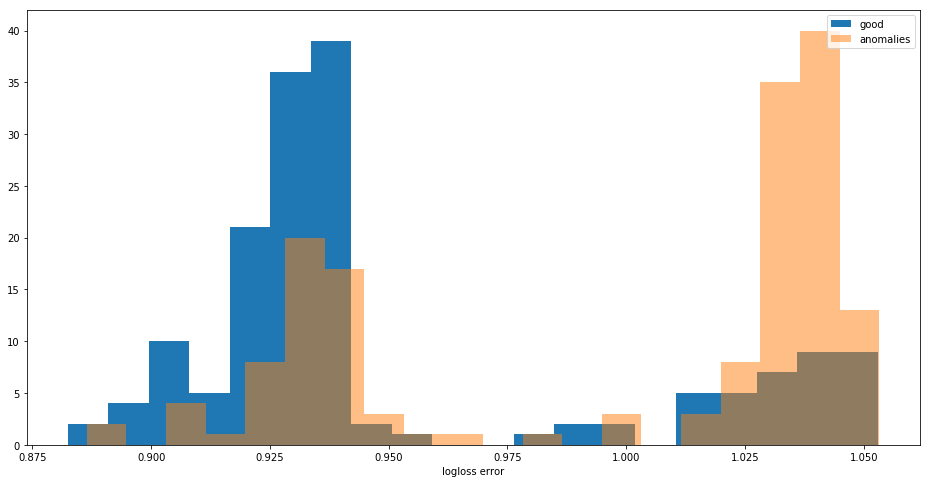

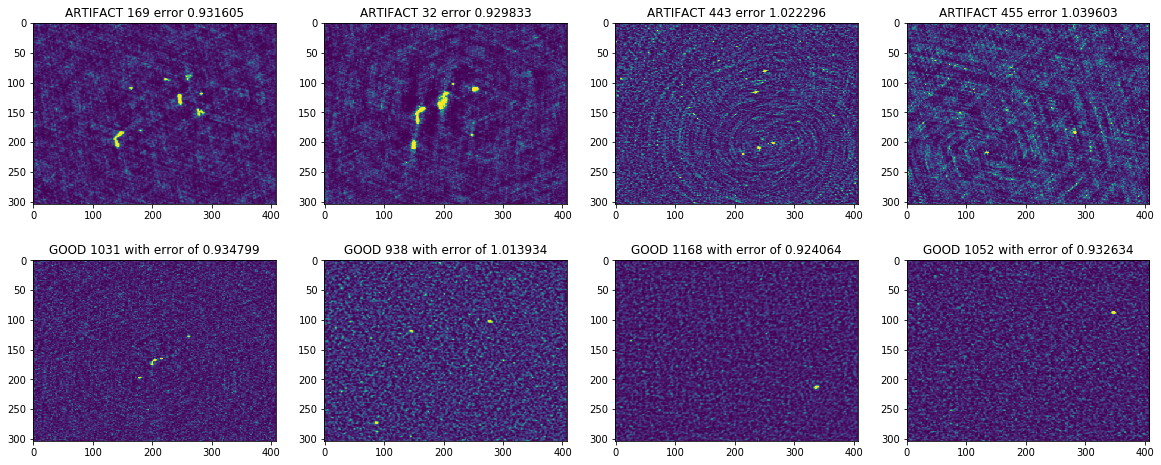

In [159]:
from matplotlib import colors
np.random.seed(42)

# load best model saved during training
detector = load_model('cnn_model.h5')

# lets check the error of our training images
# we want to see each image individually, so this takes a bit longer
baseline = []
for ss in val:
  baseline += [detector.test_on_batch(dm[ss:ss+1], dm[ss:ss+1])]
print('baseline error: ', np.mean(baseline))

# now lets see the error of some bad artifact images
bad = np.where(targets != 3)[0]
bad = np.random.choice(bad, len(val))
anomalies = []
for ss in bad:
  anomalies += [detector.test_on_batch(dm[ss:ss+1], dm[ss:ss+1])]
print('anomaly error: ', np.mean(anomalies))

# histogram the errors
plt.figure(figsize=(16,8))
plt.hist(baseline, 20, alpha=1, label='good')
plt.hist(anomalies, 20, alpha=0.5, label='anomalies')
plt.legend(loc='upper right')
plt.xlabel('logloss error')
plt.show()

# spot check some stuff
ff, aa = plt.subplots(2,4, figsize=(20,8))
samples = np.random.choice(bad, 4)
for ii,ss in enumerate(samples):
  error = detector.evaluate(dm[ss:ss+1], dm[ss:ss+1], verbose=0)
  aa[0,ii].imshow(dm[ss][:,:,0], norm=colors.PowerNorm(3))
  aa[0,ii].set_title('ARTIFACT ' + str(ss) + ' error ' + '%.6f' % error)

samples = np.random.choice(good, 4)
for ii,ss in enumerate(samples):
  error = detector.evaluate(dm[ss:ss+1], dm[ss:ss+1], verbose=0)
  aa[1,ii].imshow(dm[ss][:,:,0], norm=colors.PowerNorm(3))
  aa[1,ii].set_title('GOOD ' + str(ss) + ' with error of ' + '%.6f' % error)